# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 6.7MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Wed May 26 11:10:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc',
 'question_pair',
 'songys-chat']

In [ ]:
sychat_dir = os.path.join(data_dir, "songys-chat")
if not os.path.isdir(sychat_dir):
    os.makedirs(sychat_dir)
os.listdir(sychat_dir)

['lstm.hdf5', 'lstm.csv']

# Tutorial

In [ ]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '네가 기분이 좋으니 나도 좋아'],
    ['나는 오늘 행복해', '나도 행복하다'],
]

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())
print(words)

# 중복 단어 제거
words = list(dict.fromkeys(words))
print(words)

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)
print(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

print(id_to_word)

['나는', '오늘', '기분이', '좋아', '네가', '기분이', '좋으니', '나도', '좋아', '나는', '오늘', '행복해', '나도', '행복하다']
['나는', '오늘', '기분이', '좋아', '네가', '좋으니', '나도', '행복해', '행복하다']
{'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3, '나는': 4, '오늘': 5, '기분이': 6, '좋아': 7, '네가': 8, '좋으니': 9, '나도': 10, '행복해': 11, '행복하다': 12}
{0: '[PAD]', 1: '[UNK]', 2: '[BOS]', 3: '[EOS]', 4: '나는', 5: '오늘', 6: '기분이', 7: '좋아', 8: '네가', 9: '좋으니', 10: '나도', 11: '행복해', 12: '행복하다'}


In [ ]:
# train source, target 데이터 생성
train_src_ids, tarin_tgt_ids = [], []
for pair in sentences:
    train_src_ids.append([word_to_id[word] for word in pair[0].split()])
    tarin_tgt_ids.append([word_to_id[word] for word in pair[1].split()])
print(train_src_ids)
print(tarin_tgt_ids)

[[4, 5, 6, 7], [4, 5, 11]]
[[8, 6, 9, 10, 7], [10, 12]]


In [ ]:
# train enc_inputs, dec_inputs, dec_label 생성
train_enc_inputs, train_dec_inputs, train_dec_labels = [], [], []
for source_id, target_id in zip(train_src_ids, tarin_tgt_ids):
    train_enc_inputs.append(source_id)
    train_dec_inputs.append([word_to_id['[BOS]']] + target_id)
    train_dec_labels.append(target_id + [word_to_id['[EOS]']])
train_enc_inputs, train_dec_inputs, train_dec_labels

([[4, 5, 6, 7], [4, 5, 11]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3]])

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_inputs:
    row += [0] * (6 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_labels:
    row += [0] * (6 - len(row))

train_enc_inputs, train_dec_inputs, train_dec_labels

([[4, 5, 6, 7], [4, 5, 11, 0]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12, 0, 0, 0]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3, 0, 0, 0]])

In [ ]:
# numpy array로 변환
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_dec_labels = np.array(train_dec_labels)

train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[ 4,  5,  6,  7],
        [ 4,  5, 11,  0]]), array([[ 2,  8,  6,  9, 10,  7],
        [ 2, 10, 12,  0,  0,  0]]), array([[ 8,  6,  9, 10,  7,  3],
        [10, 12,  3,  0,  0,  0]]))

In [ ]:
# 단어를 벡터로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [ ]:
# encoder inputs 단어 벡터
enc_hidden = embedding(train_enc_inputs)  # (bs, n_seq, 4)
enc_hidden

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ]],

       [[ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.01447895, -0.01838874,  0.04926274,  0.02590281],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716]]],
      dtype=float32)>

In [ ]:
# encoder LSTM
enc_lstm = tf.keras.layers.LSTM(units=5, return_state=True)

In [ ]:
# encoder LSTM 실행
enc_hidden, enc_h_state, enc_c_state = enc_lstm(enc_hidden)
enc_hidden, enc_h_state, enc_c_state

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-0.00082123, -0.00522853, -0.0018438 , -0.00625095, -0.00216456],
        [ 0.00559843, -0.00374473,  0.00191227, -0.00659619,  0.00712104]],
       dtype=float32)>, <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-0.00082123, -0.00522853, -0.0018438 , -0.00625095, -0.00216456],
        [ 0.00559843, -0.00374473,  0.00191227, -0.00659619,  0.00712104]],
       dtype=float32)>, <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[-0.00164527, -0.01057572, -0.00372739, -0.01243458, -0.00428836],
        [ 0.01112364, -0.00752604,  0.00385827, -0.0132431 ,  0.01415312]],
       dtype=float32)>)

In [ ]:
# decoder inputs 단어 벡터
dec_hidden = embedding(train_dec_inputs)  # (bs, n_seq, 4)
dec_hidden

<tf.Tensor: shape=(2, 6, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [-0.01826397, -0.03069841,  0.03251565,  0.00923193],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292],
        [-0.01256046,  0.0343336 , -0.02595751,  0.03221213],
        [-0.03375109, -0.02327753, -0.00871272,  0.00912046],
        [-0.00544795, -0.04431503, -0.02540476, -0.0194685 ]],

       [[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [-0.03375109, -0.02327753, -0.00871272,  0.00912046],
        [-0.00891924, -0.02965369, -0.00554544, -0.04765527],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716]]],
      dtype=float32)>

In [ ]:
# decoder LSTM
dec_lstm = tf.keras.layers.LSTM(units=5, return_sequences=True)

In [ ]:
# decoder LSTM 실행
dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])
dec_hidden

<tf.Tensor: shape=(2, 6, 5), dtype=float32, numpy=
array([[[-0.00249466, -0.00307995, -0.00327494, -0.00725164,
         -0.00462817],
        [-0.00511247,  0.00286553, -0.00707264, -0.0032672 ,
         -0.00169703],
        [-0.00767549,  0.00277027, -0.00691308, -0.00053027,
          0.00276191],
        [-0.00805463, -0.00475024, -0.0011885 ,  0.00294018,
          0.00863971],
        [-0.00565409, -0.00261588, -0.00060706,  0.00615305,
          0.01086102],
        [ 0.00350299,  0.00040876,  0.00140416,  0.00345753,
          0.0058279 ]],

       [[ 0.00139186, -0.00246246,  0.00072242, -0.00765236,
          0.00218469],
        [ 0.00048451, -0.00028243,  0.00063642, -0.00177618,
          0.00576928],
        [ 0.00671119,  0.00474663, -0.00099277, -0.00274028,
         -0.00089224],
        [ 0.00684098,  0.0068049 , -0.00256293, -0.00404436,
         -0.00430561],
        [ 0.00700419,  0.00854143, -0.0040837 , -0.00513259,
         -0.00682055],
        [ 0.00714516,  

In [ ]:
# 다음단어 예측 layer
linear = tf.keras.layers.Dense(len(word_to_id), activation=tf.nn.softmax)

In [ ]:
# 다음단어 예측 실행
y_pred = linear(dec_hidden)
y_pred

<tf.Tensor: shape=(2, 6, 13), dtype=float32, numpy=
array([[[0.07716898, 0.07661305, 0.07664086, 0.07680578, 0.07687765,
         0.07710789, 0.07645434, 0.07708682, 0.07674611, 0.07692434,
         0.07732236, 0.07680716, 0.07744462],
        [0.07708991, 0.07633257, 0.07666311, 0.07673547, 0.07697011,
         0.07704493, 0.0766194 , 0.07711018, 0.07692873, 0.07712538,
         0.07735517, 0.07677005, 0.07725497],
        [0.07718162, 0.07624134, 0.07670058, 0.07662451, 0.07713696,
         0.07705552, 0.07661742, 0.0769958 , 0.07691861, 0.07714893,
         0.07736775, 0.07677547, 0.07723553],
        [0.07740643, 0.07661386, 0.07679015, 0.07650936, 0.07729887,
         0.07711311, 0.07660066, 0.07663357, 0.07675718, 0.07688096,
         0.07722329, 0.07688157, 0.077291  ],
        [0.07727183, 0.07674201, 0.07694732, 0.07661076, 0.07727483,
         0.07700405, 0.07685293, 0.07651459, 0.07691538, 0.07688914,
         0.07700407, 0.07696855, 0.07700454],
        [0.07687404, 0.07705

In [ ]:
# CE loss
tf.keras.losses.SparseCategoricalCrossentropy()(train_dec_labels, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5661802>

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args

Namespace(d_model=32, n_vocab=13, seed=1234)

In [ ]:
def build_model(args):
    enc_inputs = tf.keras.layers.Input((None,), name="enc_inputs")  # (bs, n_enc_seq)
    dec_inputs = tf.keras.layers.Input((None,), name="dec_inputs")  # (bs, n_dec_seq)
    ################################
    # Embedding
    ################################
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    enc_hidden = embedding(enc_inputs)  # (bs, n_enc_seq, d_model)
    dec_hidden = embedding(dec_inputs)  # (bs, n_dec_seq, d_model)
    ################################
    # Encoder
    ################################
    enc_lstm = tf.keras.layers.LSTM(units=args.d_model, return_state=True, name="enc_lstm")
    enc_hidden, enc_h_state, enc_c_state = enc_lstm(enc_hidden)  # (bs, units), (bs, units), (bs, units)
    ################################
    # Decoder
    ################################
    dec_lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, name="dec_lstm")
    dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])  # (bs, n_dec_seq, units)
    ################################
    # Next word prediction
    ################################
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(dec_hidden)  # (bs, n_dec_seq, n_vocab)
    ################################
    # Model
    ################################
    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

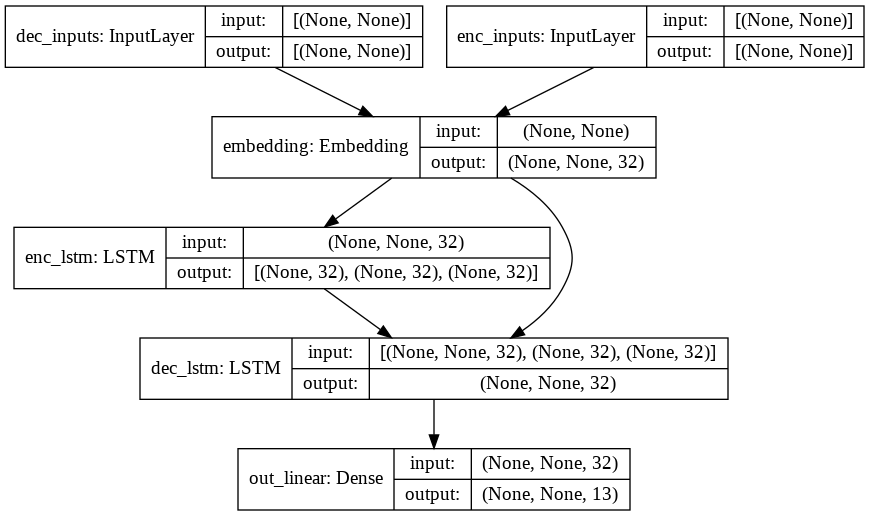

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs[:4], train_dec_inputs[:4]))

array([[[0.07669406, 0.0775681 , 0.07841668, 0.0777451 , 0.07592772,
         0.07592671, 0.07651905, 0.07630295, 0.07631198, 0.07770398,
         0.07634443, 0.07688932, 0.07764991],
        [0.07621206, 0.07743   , 0.07751198, 0.077186  , 0.07684258,
         0.07621063, 0.07682217, 0.07648059, 0.07627117, 0.07767154,
         0.07674176, 0.07715048, 0.07746906],
        [0.07598893, 0.07785374, 0.07687035, 0.07758691, 0.07719387,
         0.07609462, 0.07720447, 0.07734662, 0.07655492, 0.07611506,
         0.07648488, 0.07717209, 0.0775336 ],
        [0.07662676, 0.07782743, 0.07643627, 0.07771534, 0.07682704,
         0.07663181, 0.07699469, 0.07758945, 0.07679746, 0.07601062,
         0.07722941, 0.07666284, 0.07665084],
        [0.07663194, 0.07811173, 0.07691   , 0.07660309, 0.07662018,
         0.07641373, 0.07684214, 0.07735501, 0.07614087, 0.07601038,
         0.07704445, 0.07738463, 0.07793188],
        [0.07657768, 0.07768619, 0.0766004 , 0.07722843, 0.0772963 ,
         0.

# Vocabulary*

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

# Data*

In [ ]:
# 파일 다운로드 및 목록 확인
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
os.listdir('./')

--2021-05-26 11:12:57--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-05-26 11:12:57--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv’

ChatbotData .csv    100%[===================>] 868.99K  --.-KB/s    in 0.04s   

2021-05-26 11:12:57 (21.8 MB/s) - ‘ChatbotData .csv’ saved [889842/889842]



['.config', 'model.png', 'drive', 'ChatbotData .csv', 'sample_data']

In [ ]:
# 파일명 변경 및 목록 확인
!mv 'ChatbotData .csv' ChatbotData.csv
os.listdir('./')

['.config', 'model.png', 'ChatbotData.csv', 'drive', 'sample_data']

# Loss & Acc*

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# Small Data Project

## Train 데이터 생성

In [ ]:
# data load
df_train = pd.read_csv('ChatbotData.csv')
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# null 제거
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# Q 길이
q_length = df_train["Q"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
q_length.head(10), q_length.max()

(0     5
 1     6
 2     9
 3    10
 4     5
 5     7
 6     5
 7     7
 8    11
 9     9
 Name: Q, dtype: int64, 27)

In [ ]:
# A 길이
a_length = df_train["A"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
a_length.head(10), a_length.max()

(0    6
 1    6
 2    6
 3    6
 4    9
 5    9
 6    9
 7    7
 8    6
 9    6
 Name: A, dtype: int64, 39)

In [ ]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

,Q,A,label
11761,하루종일 썸남 생각만 해. 괜찮을까?,그것 또한 감정의 일부니까요.,2
924,냉장고에 먹을 게 하나도 없네,슈퍼라도 가서 쇼핑하고 오세요.,0
3763,인사드리러 갔는데 파혼하는게 나을것 같아,이혼이 아니라 다행입니다.,0
341,금값 어때,비싸요.,0
10736,연애상담하더니 둘이 사귀더라,대화를 하다가 친해졌나봐요.,2
5140,혼자 노래방 가면 어색할 거 같은데,신나는 노래로 분위기를 띄어보세요.,0
5713,기회도 없네.,다른 기회가 올 거예요.,1
9996,사랑한 만큼 배려해야했어,이제야 깨달았나봐요.,2
3168,여자친구가 전화를 안해,다른 연락을 많이 하거나 더 자주 만나세요.,0
9762,못생긴 남자를 좋아하는 여자가 있을지.,외모가 중요한 시대는 끝났어요.,2


In [ ]:
def make_data(df, vocab, n_enc_seq, n_dec_seq):
    """
    chat 학습 데이터 생성
    :param df: data frame
    :param df: vocab
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return dec_labels: decoder label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1  # [BOS] or [EOS]
    # inputa & labels
    enc_inputs, dec_inputs, dec_labels = [], [], []
    # 데이터 생성
    for i, row in tqdm(df.iterrows(), total=len(df)):
        Q = row['Q']
        A = row['A']
        # tokenize
        tokens_q = vocab.encode_as_ids(Q)
        tokens_a = vocab.encode_as_ids(A)
        # 최대 길이로 자르기
        tokens_q = tokens_q[:n_enc_max]
        tokens_a = tokens_a[:n_dec_max]
        # input & label 정의
        enc_input = tokens_q
        dec_input = [vocab.bos_id()] + tokens_a
        dec_label = tokens_a + [vocab.eos_id()]
        # pad 추가
        enc_input += [0] * (n_enc_seq - len(enc_input))
        dec_input += [0] * (n_dec_seq - len(dec_input))
        dec_label += [0] * (n_dec_seq - len(dec_label))
        # 값 저장
        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_labels.append(dec_label)
 
    # to numpy array
    enc_inputs = np.array(enc_inputs)
    dec_inputs = np.array(dec_inputs)
    dec_labels = np.array(dec_labels)
    return enc_inputs, dec_inputs, dec_labels

In [ ]:
train_enc_inputs, train_dec_inputs, train_dec_labels = make_data(df_train, vocab, 27, 40)
train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[ 2424,   378,    30,    10, 27556,   486,  1028,    59,   209,
             7,    10, 31855, 14969,    11,  3083,  2138,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 6740,   159,    37,    14,  9956,  1717,   477,    32,  5639,
           377,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 2482,  6720,   479, 10227,   680,   522,  2193,    42,    87,
           349,    11,  6119, 14380,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  653,  3441,   542,  1433,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 7479,   128,  1119,   277, 10922,  1687,    20, 19010,   576,
           105,     0,     0,     0,     0,     0,     0,   

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args

Namespace(d_model=256, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    enc_inputs = tf.keras.layers.Input((None,), name="enc_inputs")  # (bs, n_enc_seq)
    dec_inputs = tf.keras.layers.Input((None,), name="dec_inputs")  # (bs, n_dec_seq)
    ################################
    # Embedding
    ################################
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    enc_hidden = embedding(enc_inputs)  # (bs, n_enc_seq, d_model)
    dec_hidden = embedding(dec_inputs)  # (bs, n_dec_seq, d_model)
    ################################
    # Encoder
    ################################
    enc_lstm = tf.keras.layers.LSTM(units=args.d_model, return_state=True, name="enc_lstm")
    _, enc_h_state, enc_c_state = enc_lstm(enc_hidden)
    ################################
    # Decoder
    ################################
    dec_lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, name="dec_lstm")
    dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])
    ################################
    # Next word prediction
    ################################
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(dec_hidden)
    ################################
    # Model
    ################################
    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

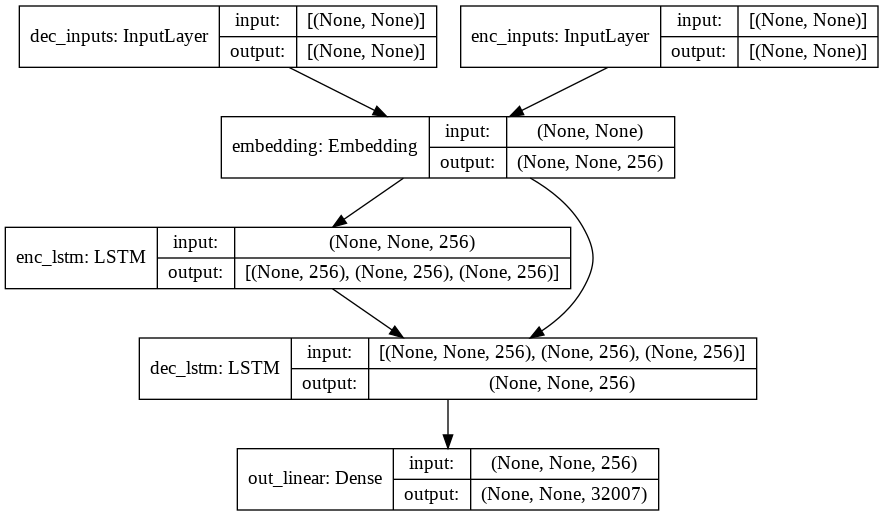

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs[:4], train_dec_inputs[:4]))

array([[[3.1313622e-05, 3.1160103e-05, 3.1245636e-05, ...,
         3.1335323e-05, 3.1099455e-05, 3.1282358e-05],
        [3.1323543e-05, 3.1171163e-05, 3.1269436e-05, ...,
         3.1312935e-05, 3.1162108e-05, 3.1313266e-05],
        [3.1312651e-05, 3.1198986e-05, 3.1268133e-05, ...,
         3.1307631e-05, 3.1155341e-05, 3.1278345e-05],
        ...,
        [3.1347412e-05, 3.1294308e-05, 3.1373980e-05, ...,
         3.1281394e-05, 3.1218991e-05, 3.1328909e-05],
        [3.1347518e-05, 3.1294217e-05, 3.1373937e-05, ...,
         3.1281357e-05, 3.1218973e-05, 3.1328891e-05],
        [3.1347608e-05, 3.1294145e-05, 3.1373904e-05, ...,
         3.1281328e-05, 3.1218962e-05, 3.1328873e-05]],

       [[3.1321051e-05, 3.1148465e-05, 3.1236712e-05, ...,
         3.1345207e-05, 3.1094431e-05, 3.1284551e-05],
        [3.1289703e-05, 3.1136555e-05, 3.1215241e-05, ...,
         3.1326508e-05, 3.1142903e-05, 3.1277046e-05],
        [3.1282605e-05, 3.1187763e-05, 3.1230556e-05, ...,
         3.127

## Train

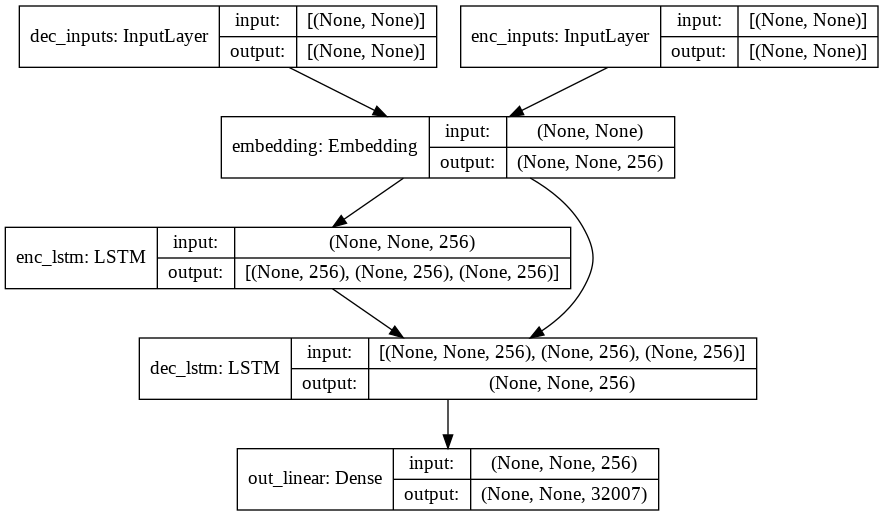

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=30)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(sychat_dir, "lstm.hdf5"),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(sychat_dir, "lstm.csv"))

In [ ]:
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_dec_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 2.3859 - lm_acc: 0.0000e+00

Epoch 00001: lm_acc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 2/100
1/1 [==============================] - 1s 738ms/step - loss: 2.3847 - lm_acc: 0.1522

Epoch 00002: lm_acc improved from 0.00000 to 0.15217, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 3/100
1/1 [==============================] - 1s 694ms/step - loss: 2.3831 - lm_acc: 0.1848

Epoch 00003: lm_acc improved from 0.15217 to 0.18478, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 4/100
1/1 [==============================] - 1s 722ms/step - loss: 2.3805 - lm_acc: 0.2174

Epoch 00004: lm_acc improved from 0.18478 to 0.21739, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 5/100
1/1 [=

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')

plt.show()

## BLEU

In [ ]:
candidate = 'the the the the the the the'.split()
references = [
    'the cat is on the mat'.split(),
    'there is a cat on the mat'.split()
]

In [ ]:
candidate, references

(['the', 'the', 'the', 'the', 'the', 'the', 'the'],
 [['the', 'cat', 'is', 'on', 'the', 'mat'],
  ['there', 'is', 'a', 'cat', 'on', 'the', 'mat']])

In [ ]:
def get_ngram(tokens, ngram):
    # print(tokens)
    # tokens n-gram
    counter = collections.defaultdict(int)
    for i in range(len(tokens) - ngram + 1):
        # n-gram 별 count
        key = tuple(tokens[i:i+ngram]) # ngram에 따라 1이면 0~1, 1~2, 2~3되는거임
        counter[key] += 1 # key값에 따라 counter를 늘려가는것!
        print(i, key, counter)
    return  counter

In [ ]:
get_ngram(candidate, 2)

0 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 1})
1 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 2})
2 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 3})
3 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 4})
4 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 5})
5 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 6})


defaultdict(int, {('the', 'the'): 6})

In [ ]:
def get_ngram_clip(candidate, references, ngram):
    # max ref counter
    max_counter = collections.defaultdict(int)
    # check max count
    for ref in references:
        ref_counter = get_ngram(ref, ngram)
        for key, cnt in ref_counter.items():
            max_counter[key] = max(max_counter[key], ref_counter.get(key, 0)) # 래퍼런스의 값과 ,max counter의 값중 큰거를 가져오겟다
    # print(max_counter)

    # max reference counter를 해서 max값
    # candidate counter
    can_counter = get_ngram(candidate, ngram)
    # clip counter
    clip_counter = collections.defaultdict(int)
    for key, cnt in can_counter.items():
        clip_counter[key] = min(can_counter[key], max_counter.get(key, 0))
    return clip_counter

In [ ]:
get_ngram_clip(candidate, references, 1)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

defaultdict(int, {('the',): 2})

In [ ]:
def get_ngram_precision(candidate, references, ngram):
    # clip counter
    clip_counter = get_ngram_clip(candidate, references, ngram)
    n_clip = sum(clip_counter.values())
    # can counter
    can_counter = get_ngram(candidate, ngram)
    n_total = sum(can_counter.values())

    return n_clip / max(n_total, 1)  # 분모 0 방지

In [ ]:
get_ngram_precision(candidate, references, 1)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

0.2857142857142857

In [ ]:
def get_brevity_penalty(candidate, references):
    can_len = len(candidate)
    ref_len = min([len(reference) for reference in references])

    if can_len == 0:  # empty string
        return 0
    elif can_len > ref_len:
        return 1
    else:
        return np.exp(1 - ref_len / can_len)

In [ ]:
get_brevity_penalty(candidate, references)

1

In [ ]:
def get_bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = get_brevity_penalty(candidate, references) # BP
    p_n = [] 
    for i in range(len(weights)): # ngram이 4이니까 
        p_n.append(get_ngram_precision(candidate, references, i + 1)) # 0,1,2,3일때를 다 계산
    score = [w * np.log(p) if p != 0 else 0 for p, w in zip(p_n, weights)] # precision과 weight를 같이 ㅓㅁ겨서
    score = np.sum(score)
    score = bp * np.exp(score)
    return score

In [ ]:
get_bleu_score(candidate, references)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

0.7311104457090247

In [ ]:
# 다른 라이브러리에서 가져올수 잇지
import nltk.translate.bleu_score as bleu
from nltk import ngrams

In [ ]:
bleu.sentence_bleu(references, candidate)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7311104457090247

In [ ]:
candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'.split()
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands'.split(),
    'It is the guiding principle which guarantees the military forces always being under the command of the Party'.split(),
    'It is the practical guide for the army always to heed the directions of the party'.split()
]

In [ ]:
get_bleu_score(candidate, references)

0 ('It',) defaultdict(<class 'int'>, {('It',): 1})
1 ('is',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1})
3 ('guide',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1})
4 ('to',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1})
5 ('action',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1})
6 ('that',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 1})
7 ('ensures',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 1, ('ensures',): 1})
8 ('that',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 2, ('ensures',): 1})
9 ('the',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, 

0.5045666840058485

In [ ]:
bleu.sentence_bleu(references, candidate)

# 음 코드가 문제 없이 잘 돌아가고 있다는걸 알수가 있지

0.5045666840058485

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm.hdf5"))

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
# 100개만 확인
valid_enc_inputs = train_enc_inputs[:100]
valid_dec_inputs = train_dec_inputs[:100]
valid_dec_labels = train_dec_labels[:100]

In [ ]:
# 평가
model.evaluate((valid_enc_inputs, valid_dec_inputs), valid_dec_labels, batch_size=128)

1/1 [==============================] - 2s 2s/step - loss: 2.3758 - lm_acc: 0.2174


[2.3757662773132324, 0.21739129722118378]

In [ ]:
references = []
for row in valid_dec_labels: # 이거는 디코더 label이고
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    references.append(string)
references

[['▁그것', '▁또한', '▁감정', '의', '▁일부', '니까', '요', '.'],
 ['▁슈퍼', '라도', '▁가서', '▁쇼핑', '하고', '▁오', '세요', '.'],
 ['▁이혼', '이', '▁아니라', '▁다', '행', '입니다', '.'],
 ['▁비싸', '요', '.'],
 ['▁대화', '를', '▁하다가', '▁친', '해', '졌', '나', '봐', '요', '.'],
 ['▁신', '나', '는', '▁노래로', '▁분위기', '를', '▁', '띄', '어', '보', '세요', '.'],
 ['▁다른', '▁기회', '가', '▁올', '▁거', '예', '요', '.'],
 ['▁이제', '야', '▁깨달았', '나', '봐', '요', '.'],
 ['▁다른', '▁연락', '을', '▁많이', '▁하거나', '▁더', '▁자주', '▁만나', '세요', '.'],
 ['▁외모', '가', '▁중요한', '▁시대', '는', '▁끝', '났', '어요', '.']]

In [ ]:
# 예측
y_pred = model.predict((valid_enc_inputs, valid_dec_inputs))
y_pred.shape

(10, 40, 32007)

In [ ]:
# greedy decoding
y_pred_class = tf.argmax(y_pred, axis=-1).numpy()
y_pred_class

array([[ 506,  506,  506,  506,  506,    7,    7,    7,    3,    3,    3,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,  506,    7,    7,    7,    3,    7,    7,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,  506,  506,    7,    3,    7,    7,    7,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,    7,    7,    7,    7,    7,    7,    7,
           7,    7,    7,    7,    7,   57,   57,   57,   57,   57,   57,
          57,   57,   57,   57,  

In [ ]:
candidates = []
for row in y_pred_class:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    candidates.append(string)
candidates

[['요', '요', '요', '요', '요', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.'],
 ['요',
  '요',
  '요',
  '요',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회'],
 ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.'],
 ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '.', '.', '.', '.', '.']]

In [ ]:
bleu_scores = []
for reference, candidate in zip(references, candidates):
    bleu_score = bleu.sentence_bleu([reference], candidate)
    bleu_scores.append(bleu_score)
    print(bleu_score, ":", reference, "/", candidate)
np.mean(bleu_scores)

0.43472087194499137 : ['▁그것', '▁또한', '▁감정', '의', '▁일부', '니까', '요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.']
0.5946035575013605 : ['▁슈퍼', '라도', '▁가서', '▁쇼핑', '하고', '▁오', '세요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.']
0.6147881529512643 : ['▁이혼', '이', '▁아니라', '▁다', '행', '입니다', '.'] / ['요', '요', '요', '요', '요', '요', '.']
0.1892240568795935 : ['▁비싸', '요', '.'] / ['요', '요', '요', '요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회']
0.3860973950960897 : ['▁대화', '를', '▁하다가', '▁친', '해', '졌', '나', '봐', '요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.']
0.537284965911771 : ['▁신', '나', '는', '▁노래로', '▁분위기', '를', '▁', '띄', '어', '보', '세요', '.'] / ['요', '요', '요', '요', '요', '요', '.', '.', '.', '.', '.', '.']
0.43472087194499137 : ['▁다른', '▁기회', '가', '▁올', '▁거', '예', '요', '.'] / ['요', '요', '요', '요', '요', '요', '.', '.']
0.467137977728

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4798269444338237

## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm.hdf5"))

In [ ]:
def do_chat(vocab, model, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string) # 입력 문장
    q_id = [vocab.piece_to_id(p) for p in q]
    # print(q)

    # answer # 대답 문장
    a_id = [vocab.bos_id()]
    # print(a_id)
    # 처음부터 예측
    start_idx = 0 # Bos지 이거 지금

    # 어디까지 예측하느냐
    for _ in range(start_idx, n_dec_seq - 1): # eos 때문에
        # print(q_id)
        # print(a_id)
        outputs = model.predict((np.array([q_id]), np.array([a_id]))) # (bs, n_seq, n_vocab) #predict(en_input, dec_input = bos)
        prob = outputs[0][start_idx] # 이때 우리 batch_size = 1이니까
        print(prob.shape) # 32007개의 확률분포가 뽑혔지

        word_id = int(np.argmax(prob)) # 이제 greedy하게 뽑아보자 word_id에 저장되고
        print(word_id)

        if word_id == vocab.eos_id(): #그리고 eos의 id가 오면 끝내라!
            break
        a_id.append(word_id)        
        start_idx += 1 # 뒤 단어가 계속 예측하도록 하겠지

    predict_id = a_id[1:start_idx + 1] # 이게 bos빼고 decoder의 input으로 들어가는건가
    # print(predict_id)
    predict_str = vocab.decode_ids(predict_id) # 받은 아이디를 string으로 바꿔야지
    return predict_str

In [ ]:
string = '남에게 피해주지 않는 건 기본이죠.'
do_chat(vocab, model, 40, string)

'슈퍼요.'

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, 40, string)
    print(f'답변 > {predict_str}')

질문 > ㅎ2
답변 > 요.
질문 > 요는 뭐야
답변 > 이혼.
질문 > 이혼?
답변 > 이혼나요.
질문 > 뭐래ㅋㅋ
답변 > 신나요
질문 > 미친놈ㅋㅋ
답변 > 연락 많이 하거나.
질문 > 오 ㅇㅋ
답변 > 다른요.


KeyboardInterrupt: ignored

# All Data Project

## Train 데이터 생성

In [ ]:
# data load
df_train = pd.read_csv('ChatbotData.csv')
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# null 제거
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# Q 길이
q_length = df_train["Q"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
q_length.head(10), q_length.max()

(0     5
 1     6
 2     9
 3    10
 4     5
 5     7
 6     5
 7     7
 8    11
 9     9
 Name: Q, dtype: int64, 27)

In [ ]:
# A 길이
a_length = df_train["A"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
a_length.head(10), a_length.max()

(0    6
 1    6
 2    6
 3    6
 4    9
 5    9
 6    9
 7    7
 8    6
 9    6
 Name: A, dtype: int64, 39)

In [ ]:
# # 랜덤하게 10개만 확인
# df_train = df_train.sample(10)
# df_train

In [ ]:
def make_data(df, vocab, n_enc_seq, n_dec_seq):
    """
    chat 학습 데이터 생성
    :param df: data frame
    :param df: vocab
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return dec_labels: decoder label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1  # [BOS] or [EOS]
    # inputa & labels
    enc_inputs, dec_inputs, dec_labels = [], [], []
    # 데이터 생성
    for i, row in tqdm(df.iterrows(), total=len(df)):
        Q = row['Q']
        A = row['A']
        # tokenize
        tokens_q = vocab.encode_as_ids(Q)
        tokens_a = vocab.encode_as_ids(A)
        # 최대 길이로 자르기
        tokens_q = tokens_q[:n_enc_max]
        tokens_a = tokens_a[:n_dec_max]
        # input & label 정의
        enc_input = tokens_q
        dec_input = [vocab.bos_id()] + tokens_a
        dec_label = tokens_a + [vocab.eos_id()]
        # pad 추가
        enc_input += [0] * (n_enc_seq - len(enc_input))
        dec_input += [0] * (n_dec_seq - len(dec_input))
        dec_label += [0] * (n_dec_seq - len(dec_label))
        # 값 저장
        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_labels.append(dec_label)
 
    # to numpy array
    enc_inputs = np.array(enc_inputs)
    dec_inputs = np.array(dec_inputs)
    dec_labels = np.array(dec_labels)
    return enc_inputs, dec_inputs, dec_labels

In [ ]:
train_enc_inputs, train_dec_inputs, train_dec_labels = make_data(df_train, vocab, 27, 40)
train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[   92,    56,    10, ...,     0,     0,     0],
        [   36,    44,  1075, ...,     0,     0,     0],
        [   39,   999,   387, ...,     0,     0,     0],
        ...,
        [ 3531,  8607, 18488, ...,     0,     0,     0],
        [10149,  7479,  1232, ...,     0,     0,     0],
        [21584,    71,  1113, ...,     0,     0,     0]]),
 array([[    2,  2424,    19, ...,     0,     0,     0],
        [    2,  3975,    61, ...,     0,     0,     0],
        [    2,  1910,    18, ...,     0,     0,     0],
        ...,
        [    2,  1695,     1, ...,     0,     0,     0],
        [    2,   423,  9250, ...,     0,     0,     0],
        [    2, 14787,    98, ...,     0,     0,     0]]),
 array([[ 2424,    19,   345, ...,     0,     0,     0],
        [ 3975,    61,   976, ...,     0,     0,     0],
        [ 1910,    18,  8244, ...,     0,     0,     0],
        ...,
        [ 1695,     1,  8406, ...,     0,     0,     0],
        [  423,  9250,   507, ...,     0,    

In [ ]:
train_enc_inputs.shape, train_dec_inputs.shape, train_dec_labels.shape

((11823, 27), (11823, 40), (11823, 40))

In [ ]:
train_enc_inputs.shape, train_enc_inputs.shape[0] * train_enc_inputs.shape[1]

((11823, 27), 319221)

In [ ]:
# 인코더에 padding이 얼마나 많은지 확인해볼게
train_enc_inputs == 0

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [ ]:
np.sum(train_enc_inputs == 0)


234375

In [ ]:
234375 / 319221

0.7342092155591268

In [ ]:
# 디코더에 padding이 훨씬 많네!
# token당으로 해야 padding을 확인할수 있으니까
# token 가로,세로 곱해서 다 해본거지

train_dec_inputs.shape, train_dec_inputs.shape[0] * train_dec_inputs.shape[1]

((11823, 40), 472920)

In [ ]:
train_dec_inputs == 0

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [ ]:
np.sum(train_dec_inputs == 0)

358254

In [ ]:
358254 / 472920

0.7575361583354479

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args

Namespace(d_model=256, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    enc_inputs = tf.keras.layers.Input((None,), name="enc_inputs")  # (bs, n_enc_seq)
    dec_inputs = tf.keras.layers.Input((None,), name="dec_inputs")  # (bs, n_dec_seq)
    ################################
    # Embedding
    ################################
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    enc_hidden = embedding(enc_inputs)  # (bs, n_enc_seq, d_model)
    dec_hidden = embedding(dec_inputs)  # (bs, n_dec_seq, d_model)
    ################################
    # Encoder
    ################################
    enc_lstm = tf.keras.layers.LSTM(units=args.d_model, return_state=True, name="enc_lstm")
    _, enc_h_state, enc_c_state = enc_lstm(enc_hidden)
    ################################
    # Decoder
    ################################
    dec_lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, name="dec_lstm")
    dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])
    ################################
    # Next word prediction
    ################################
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(dec_hidden)
    ################################
    # Model
    ################################
    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

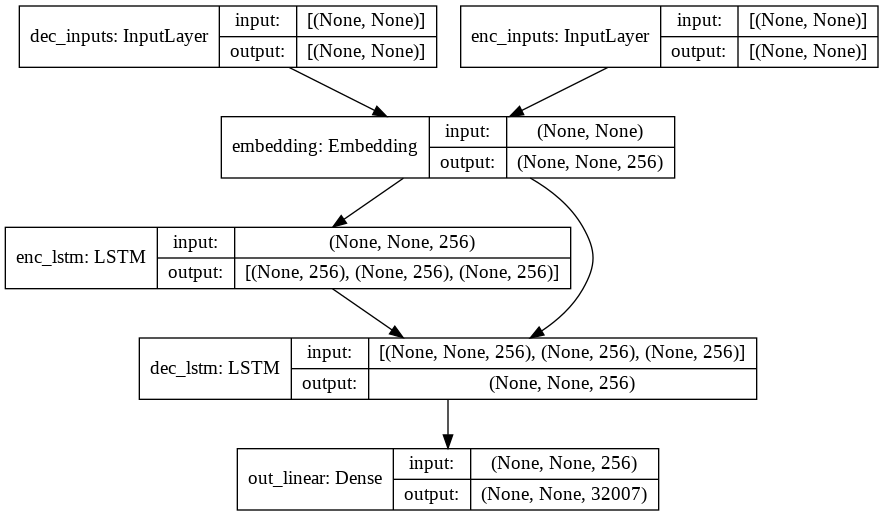

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs[:4], train_dec_inputs[:4]))

array([[[3.1313622e-05, 3.1160103e-05, 3.1245636e-05, ...,
         3.1335323e-05, 3.1099455e-05, 3.1282358e-05],
        [3.1323543e-05, 3.1171163e-05, 3.1269436e-05, ...,
         3.1312935e-05, 3.1162108e-05, 3.1313266e-05],
        [3.1312651e-05, 3.1198986e-05, 3.1268133e-05, ...,
         3.1307631e-05, 3.1155341e-05, 3.1278345e-05],
        ...,
        [3.1347412e-05, 3.1294308e-05, 3.1373980e-05, ...,
         3.1281394e-05, 3.1218991e-05, 3.1328909e-05],
        [3.1347518e-05, 3.1294217e-05, 3.1373937e-05, ...,
         3.1281357e-05, 3.1218973e-05, 3.1328891e-05],
        [3.1347608e-05, 3.1294145e-05, 3.1373904e-05, ...,
         3.1281328e-05, 3.1218962e-05, 3.1328873e-05]],

       [[3.1321051e-05, 3.1148465e-05, 3.1236712e-05, ...,
         3.1345207e-05, 3.1094431e-05, 3.1284551e-05],
        [3.1289703e-05, 3.1136555e-05, 3.1215241e-05, ...,
         3.1326508e-05, 3.1142903e-05, 3.1277046e-05],
        [3.1282605e-05, 3.1187763e-05, 3.1230556e-05, ...,
         3.127

## Train

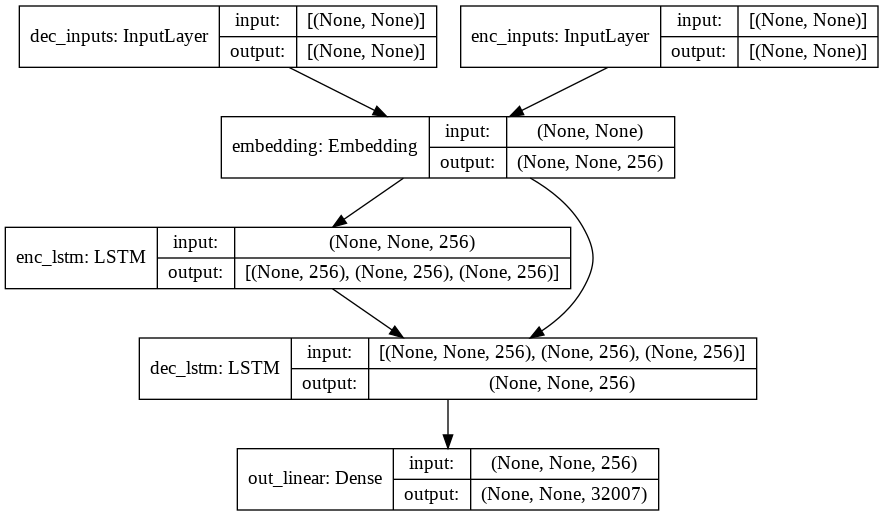

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=30)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(sychat_dir, "lstm.hdf5"),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(sychat_dir, "lstm.csv"))

In [ ]:
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_dec_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
47/47 [==============================] - 19s 343ms/step - loss: 1.7660 - lm_acc: 0.1082

Epoch 00001: lm_acc improved from -inf to 0.10816, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 2/100
47/47 [==============================] - 16s 344ms/step - loss: 1.3411 - lm_acc: 0.1064

Epoch 00002: lm_acc did not improve from 0.10816
Epoch 3/100
47/47 [==============================] - 16s 347ms/step - loss: 1.3069 - lm_acc: 0.1179

Epoch 00003: lm_acc improved from 0.10816 to 0.11786, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 4/100
47/47 [==============================] - 17s 355ms/step - loss: 1.2651 - lm_acc: 0.1273

Epoch 00004: lm_acc improved from 0.11786 to 0.12734, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/songys-chat/lstm.hdf5
Epoch 5/100
47/47 [==============================] - 17s 352ms/step - loss: 1.2200 - lm_acc: 0.2153

Epoch

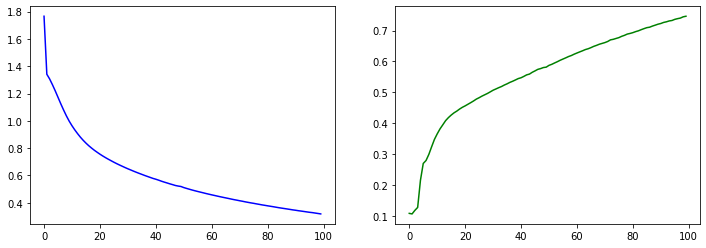

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')

plt.show()

## BLEU

In [ ]:
candidate = 'the the the the the the the'.split()
references = [
    'the cat is on the mat'.split(),
    'there is a cat on the mat'.split()
]

In [ ]:
candidate, references

(['the', 'the', 'the', 'the', 'the', 'the', 'the'],
 [['the', 'cat', 'is', 'on', 'the', 'mat'],
  ['there', 'is', 'a', 'cat', 'on', 'the', 'mat']])

In [ ]:
def get_ngram(tokens, ngram):
    # print(tokens)
    # tokens n-gram
    counter = collections.defaultdict(int)
    for i in range(len(tokens) - ngram + 1):
        # n-gram 별 count
        key = tuple(tokens[i:i+ngram]) # ngram에 따라 1이면 0~1, 1~2, 2~3되는거임
        counter[key] += 1 # key값에 따라 counter를 늘려가는것!
        print(i, key, counter)
    return  counter

In [ ]:
get_ngram(candidate, 2)

0 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 1})
1 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 2})
2 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 3})
3 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 4})
4 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 5})
5 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 6})


defaultdict(int, {('the', 'the'): 6})

In [ ]:
def get_ngram_clip(candidate, references, ngram):
    # max ref counter
    max_counter = collections.defaultdict(int)
    # check max count
    for ref in references:
        ref_counter = get_ngram(ref, ngram)
        for key, cnt in ref_counter.items():
            max_counter[key] = max(max_counter[key], ref_counter.get(key, 0)) # 래퍼런스의 값과 ,max counter의 값중 큰거를 가져오겟다
    # print(max_counter)

    # max reference counter를 해서 max값
    # candidate counter
    can_counter = get_ngram(candidate, ngram)
    # clip counter
    clip_counter = collections.defaultdict(int)
    for key, cnt in can_counter.items():
        clip_counter[key] = min(can_counter[key], max_counter.get(key, 0))
    return clip_counter

In [ ]:
get_ngram_clip(candidate, references, 1)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

defaultdict(int, {('the',): 2})

In [ ]:
def get_ngram_precision(candidate, references, ngram):
    # clip counter
    clip_counter = get_ngram_clip(candidate, references, ngram)
    n_clip = sum(clip_counter.values())
    # can counter
    can_counter = get_ngram(candidate, ngram)
    n_total = sum(can_counter.values())

    return n_clip / max(n_total, 1)  # 분모 0 방지

In [ ]:
get_ngram_precision(candidate, references, 1)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

0.2857142857142857

In [ ]:
def get_brevity_penalty(candidate, references):
    can_len = len(candidate)
    ref_len = min([len(reference) for reference in references])

    if can_len == 0:  # empty string
        return 0
    elif can_len > ref_len:
        return 1
    else:
        return np.exp(1 - ref_len / can_len)

In [ ]:
get_brevity_penalty(candidate, references)

1

In [ ]:
def get_bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = get_brevity_penalty(candidate, references) # BP
    p_n = [] 
    for i in range(len(weights)): # ngram이 4이니까 
        p_n.append(get_ngram_precision(candidate, references, i + 1)) # 0,1,2,3일때를 다 계산
    score = [w * np.log(p) if p != 0 else 0 for p, w in zip(p_n, weights)] # precision과 weight를 같이 ㅓㅁ겨서
    score = np.sum(score)
    score = bp * np.exp(score)
    return score

In [ ]:
get_bleu_score(candidate, references)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

0.7311104457090247

In [ ]:
# 다른 라이브러리에서 가져올수 잇지
import nltk.translate.bleu_score as bleu
from nltk import ngrams

In [ ]:
bleu.sentence_bleu(references, candidate)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7311104457090247

In [ ]:
candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'.split()
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands'.split(),
    'It is the guiding principle which guarantees the military forces always being under the command of the Party'.split(),
    'It is the practical guide for the army always to heed the directions of the party'.split()
]

In [ ]:
get_bleu_score(candidate, references)

0 ('It',) defaultdict(<class 'int'>, {('It',): 1})
1 ('is',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1})
3 ('guide',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1})
4 ('to',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1})
5 ('action',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1})
6 ('that',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 1})
7 ('ensures',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 1, ('ensures',): 1})
8 ('that',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 2, ('ensures',): 1})
9 ('the',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, 

0.5045666840058485

In [ ]:
bleu.sentence_bleu(references, candidate)

# 음 코드가 문제 없이 잘 돌아가고 있다는걸 알수가 있지

0.5045666840058485

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm.hdf5"))

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
# 100개만 확인
valid_enc_inputs = train_enc_inputs[:100]
valid_dec_inputs = train_dec_inputs[:100]
valid_dec_labels = train_dec_labels[:100]

In [ ]:
# 평가
model.evaluate((valid_enc_inputs, valid_dec_inputs), valid_dec_labels, batch_size=128)

1/1 [==============================] - 2s 2s/step - loss: 2.3758 - lm_acc: 0.2174


[2.3757662773132324, 0.21739129722118378]

In [ ]:
references = []
for row in valid_dec_labels: # 이거는 디코더 label이고
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    references.append(string)
references

[['▁그것', '▁또한', '▁감정', '의', '▁일부', '니까', '요', '.'],
 ['▁슈퍼', '라도', '▁가서', '▁쇼핑', '하고', '▁오', '세요', '.'],
 ['▁이혼', '이', '▁아니라', '▁다', '행', '입니다', '.'],
 ['▁비싸', '요', '.'],
 ['▁대화', '를', '▁하다가', '▁친', '해', '졌', '나', '봐', '요', '.'],
 ['▁신', '나', '는', '▁노래로', '▁분위기', '를', '▁', '띄', '어', '보', '세요', '.'],
 ['▁다른', '▁기회', '가', '▁올', '▁거', '예', '요', '.'],
 ['▁이제', '야', '▁깨달았', '나', '봐', '요', '.'],
 ['▁다른', '▁연락', '을', '▁많이', '▁하거나', '▁더', '▁자주', '▁만나', '세요', '.'],
 ['▁외모', '가', '▁중요한', '▁시대', '는', '▁끝', '났', '어요', '.']]

In [ ]:
# 예측
y_pred = model.predict((valid_enc_inputs, valid_dec_inputs))
y_pred.shape

(10, 40, 32007)

In [ ]:
# greedy decoding
y_pred_class = tf.argmax(y_pred, axis=-1).numpy()
y_pred_class

array([[ 506,  506,  506,  506,  506,    7,    7,    7,    3,    3,    3,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,  506,    7,    7,    7,    3,    7,    7,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,  506,  506,    7,    3,    7,    7,    7,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,    7,    7,    7,    7,    7,    7,    7,
           7,    7,    7,    7,    7,   57,   57,   57,   57,   57,   57,
          57,   57,   57,   57,  

In [ ]:
candidates = []
for row in y_pred_class:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    candidates.append(string)
candidates

[['요', '요', '요', '요', '요', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.'],
 ['요',
  '요',
  '요',
  '요',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회'],
 ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.'],
 ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '.', '.', '.', '.', '.']]

In [ ]:
bleu_scores = []
for reference, candidate in zip(references, candidates):
    bleu_score = bleu.sentence_bleu([reference], candidate)
    bleu_scores.append(bleu_score)
    print(bleu_score, ":", reference, "/", candidate)
np.mean(bleu_scores)

0.43472087194499137 : ['▁그것', '▁또한', '▁감정', '의', '▁일부', '니까', '요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.']
0.5946035575013605 : ['▁슈퍼', '라도', '▁가서', '▁쇼핑', '하고', '▁오', '세요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.']
0.6147881529512643 : ['▁이혼', '이', '▁아니라', '▁다', '행', '입니다', '.'] / ['요', '요', '요', '요', '요', '요', '.']
0.1892240568795935 : ['▁비싸', '요', '.'] / ['요', '요', '요', '요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회']
0.3860973950960897 : ['▁대화', '를', '▁하다가', '▁친', '해', '졌', '나', '봐', '요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.']
0.537284965911771 : ['▁신', '나', '는', '▁노래로', '▁분위기', '를', '▁', '띄', '어', '보', '세요', '.'] / ['요', '요', '요', '요', '요', '요', '.', '.', '.', '.', '.', '.']
0.43472087194499137 : ['▁다른', '▁기회', '가', '▁올', '▁거', '예', '요', '.'] / ['요', '요', '요', '요', '요', '요', '.', '.']
0.467137977728

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4798269444338237

## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm.hdf5"))

In [ ]:
def do_chat(vocab, model, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string) # 입력 문장
    q_id = [vocab.piece_to_id(p) for p in q]
    # print(q)

    # answer # 대답 문장
    a_id = [vocab.bos_id()]
    # print(a_id)
    # 처음부터 예측
    start_idx = 0 # Bos지 이거 지금

    # 어디까지 예측하느냐
    for _ in range(start_idx, n_dec_seq - 1):
        # print(q_id)
        # print(a_id)
        outputs = model.predict((np.array([q_id]), np.array([a_id]))) # (bs, n_seq, n_vocab)
        prob = outputs[0][start_idx] # 이때 우리 batch_size = 1이니까
        # print(prob.shape) # 32007개의 확률분포가 뽑혔지

        word_id = int(np.argmax(prob)) # 이제 greedy하게 뽑아보자 word_id에 저장되고
        # print(word_id)

        if word_id == vocab.eos_id(): #그리고 eos의 id가 오면 끝내라!
            break
        a_id.append(word_id)        
        start_idx += 1 # 뒤 단어가 계속 예측하도록 하겠지

    predict_id = a_id[1:start_idx + 1]
    # print(predict_id)
    predict_str = vocab.decode_ids(predict_id) # 받은 아이디를 string으로 바꿔야지
    return predict_str

In [ ]:
string = '남에게 피해주지 않는 건 기본이죠.'
do_chat(vocab, model, 40, string)

'좋은 사람 만나지 마세요.'

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, 40, string)
    print(f'답변 > {predict_str}')

질문 > 만나서 반가워
답변 > 기다려보세요.
질문 > 어떤걸?
답변 > 기다려보세요.
질문 > 아니 그니까 뭘ㅋㅋ
답변 > 좋은 선택일 거예요.
질문 > 여행을 가고 싶어
답변 > 마음 정리가 필요 없어요.
질문 > 기분이 나빠
답변 > 기다려보세요.
질문 > 기분이 좋아
답변 > 기다려보세요!
질문 > 음..
답변 > 아니길 바라요.


KeyboardInterrupt: ignored

# no mask Data Project

## Train 데이터 생성

In [ ]:
# data load
df_train = pd.read_csv('ChatbotData.csv')
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# null 제거
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
# Q 길이
q_length = df_train["Q"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
q_length.head(10), q_length.max()

(0     5
 1     6
 2     9
 3    10
 4     5
 5     7
 6     5
 7     7
 8    11
 9     9
 Name: Q, dtype: int64, 27)

In [ ]:
# A 길이
a_length = df_train["A"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
a_length.head(10), a_length.max()

(0    6
 1    6
 2    6
 3    6
 4    9
 5    9
 6    9
 7    7
 8    6
 9    6
 Name: A, dtype: int64, 39)

In [ ]:
# # 랜덤하게 10개만 확인
# df_train = df_train.sample(10)
# df_train

In [ ]:
def make_data(df, vocab, n_enc_seq, n_dec_seq):
    """
    chat 학습 데이터 생성
    :param df: data frame
    :param df: vocab
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return dec_labels: decoder label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1  # [BOS] or [EOS]
    # inputa & labels
    enc_inputs, dec_inputs, dec_labels = [], [], []
    # 데이터 생성
    for i, row in tqdm(df.iterrows(), total=len(df)):
        Q = row['Q']
        A = row['A']
        # tokenize
        tokens_q = vocab.encode_as_ids(Q)
        tokens_a = vocab.encode_as_ids(A)
        # 최대 길이로 자르기
        tokens_q = tokens_q[:n_enc_max]
        tokens_a = tokens_a[:n_dec_max]
        # input & label 정의
        enc_input = tokens_q
        dec_input = [vocab.bos_id()] + tokens_a
        dec_label = tokens_a + [vocab.eos_id()]
        # pad 추가
        enc_input += [0] * (n_enc_seq - len(enc_input))
        dec_input += [0] * (n_dec_seq - len(dec_input))
        dec_label += [0] * (n_dec_seq - len(dec_label))
        # 값 저장
        enc_inputs.append(enc_input)
        dec_inputs.append(dec_input)
        dec_labels.append(dec_label)
 
    # to numpy array
    enc_inputs = np.array(enc_inputs)
    dec_inputs = np.array(dec_inputs)
    dec_labels = np.array(dec_labels)
    return enc_inputs, dec_inputs, dec_labels

In [ ]:
train_enc_inputs, train_dec_inputs, train_dec_labels = make_data(df_train, vocab, 27, 40)
train_enc_inputs, train_dec_inputs, train_dec_labels

(array([[   92,    56,    10, ...,     0,     0,     0],
        [   36,    44,  1075, ...,     0,     0,     0],
        [   39,   999,   387, ...,     0,     0,     0],
        ...,
        [ 3531,  8607, 18488, ...,     0,     0,     0],
        [10149,  7479,  1232, ...,     0,     0,     0],
        [21584,    71,  1113, ...,     0,     0,     0]]),
 array([[    2,  2424,    19, ...,     0,     0,     0],
        [    2,  3975,    61, ...,     0,     0,     0],
        [    2,  1910,    18, ...,     0,     0,     0],
        ...,
        [    2,  1695,     1, ...,     0,     0,     0],
        [    2,   423,  9250, ...,     0,     0,     0],
        [    2, 14787,    98, ...,     0,     0,     0]]),
 array([[ 2424,    19,   345, ...,     0,     0,     0],
        [ 3975,    61,   976, ...,     0,     0,     0],
        [ 1910,    18,  8244, ...,     0,     0,     0],
        ...,
        [ 1695,     1,  8406, ...,     0,     0,     0],
        [  423,  9250,   507, ...,     0,    

In [ ]:
train_enc_inputs.shape, train_dec_inputs.shape, train_dec_labels.shape

((11823, 27), (11823, 40), (11823, 40))

In [ ]:
train_enc_inputs.shape, train_enc_inputs.shape[0] * train_enc_inputs.shape[1]

((11823, 27), 319221)

In [ ]:
# 인코더에 padding이 얼마나 많은지 확인해볼게
train_enc_inputs == 0

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [ ]:
np.sum(train_enc_inputs == 0)


234375

In [ ]:
234375 / 319221

0.7342092155591268

In [ ]:
# 디코더에 padding이 훨씬 많네!
# token당으로 해야 padding을 확인할수 있으니까
# token 가로,세로 곱해서 다 해본거지

train_dec_inputs.shape, train_dec_inputs.shape[0] * train_dec_inputs.shape[1]

((11823, 40), 472920)

In [ ]:
train_dec_inputs == 0

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [ ]:
np.sum(train_dec_inputs == 0)

358254

In [ ]:
358254 / 472920

0.7575361583354479

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args

Namespace(d_model=256, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    enc_inputs = tf.keras.layers.Input((None,), name="enc_inputs")  # (bs, n_enc_seq)
    dec_inputs = tf.keras.layers.Input((None,), name="dec_inputs")  # (bs, n_dec_seq)
    ################################
    # Embedding
    ################################
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, name="embedding")
    enc_hidden = embedding(enc_inputs)  # (bs, n_enc_seq, d_model)
    dec_hidden = embedding(dec_inputs)  # (bs, n_dec_seq, d_model)
    ################################
    # Encoder
    ################################
    enc_lstm = tf.keras.layers.LSTM(units=args.d_model, return_state=True, name="enc_lstm")
    _, enc_h_state, enc_c_state = enc_lstm(enc_hidden)
    ################################
    # Decoder
    ################################
    dec_lstm = tf.keras.layers.LSTM(units=args.d_model, return_sequences=True, name="dec_lstm")
    dec_hidden = dec_lstm(dec_hidden, initial_state=[enc_h_state, enc_c_state])
    ################################
    # Next word prediction
    ################################
    linear = tf.keras.layers.Dense(args.n_vocab, activation=tf.nn.softmax, name="out_linear")
    y_pred = linear(dec_hidden)
    ################################
    # Model
    ################################
    model = tf.keras.Model(inputs=(enc_inputs, dec_inputs), outputs=y_pred)
    return model

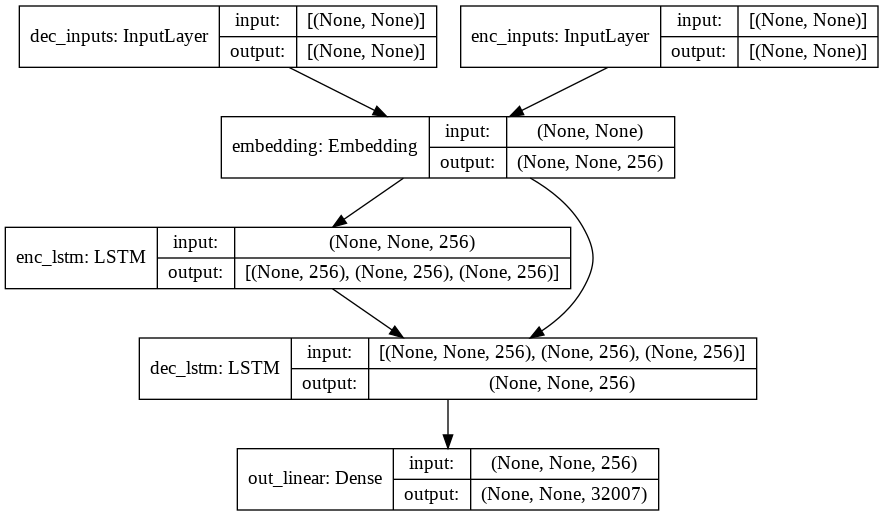

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_enc_inputs[:4], train_dec_inputs[:4]))

array([[[3.1296706e-05, 3.1231230e-05, 3.1270010e-05, ...,
         3.1193744e-05, 3.1293752e-05, 3.1247866e-05],
        [3.1268446e-05, 3.1228436e-05, 3.1282660e-05, ...,
         3.1193591e-05, 3.1281084e-05, 3.1259013e-05],
        [3.1265256e-05, 3.1227428e-05, 3.1317111e-05, ...,
         3.1210035e-05, 3.1256339e-05, 3.1256106e-05],
        ...,
        [3.1309573e-05, 3.1209707e-05, 3.1253912e-05, ...,
         3.1295091e-05, 3.1256594e-05, 3.1334002e-05],
        [3.1309581e-05, 3.1209605e-05, 3.1253960e-05, ...,
         3.1295160e-05, 3.1256630e-05, 3.1333941e-05],
        [3.1309592e-05, 3.1209518e-05, 3.1254000e-05, ...,
         3.1295218e-05, 3.1256659e-05, 3.1333882e-05]],

       [[3.1297634e-05, 3.1230833e-05, 3.1270083e-05, ...,
         3.1194253e-05, 3.1294505e-05, 3.1248197e-05],
        [3.1246243e-05, 3.1233852e-05, 3.1300995e-05, ...,
         3.1183048e-05, 3.1309864e-05, 3.1271593e-05],
        [3.1246840e-05, 3.1251155e-05, 3.1274874e-05, ...,
         3.122

## Train

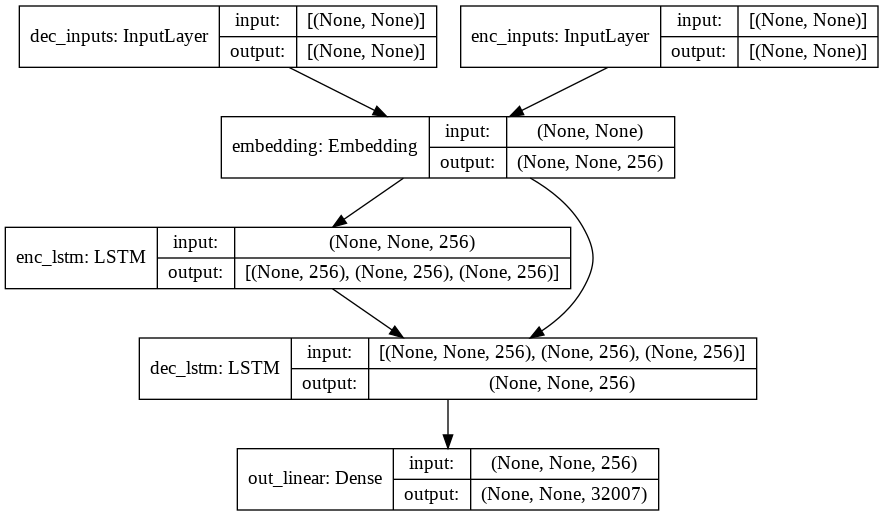

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=30)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(sychat_dir, "lstm.hdf5"),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(sychat_dir, "lstm.csv"))

In [ ]:
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_dec_labels,
                    epochs=50,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/50
47/47 [==============================] - 19s 359ms/step - loss: 4.5668 - accuracy: 0.7411
Epoch 2/50
47/47 [==============================] - 17s 370ms/step - loss: 1.5355 - accuracy: 0.7575
Epoch 3/50
47/47 [==============================] - 17s 372ms/step - loss: 1.4310 - accuracy: 0.7621
Epoch 4/50
47/47 [==============================] - 17s 365ms/step - loss: 1.3384 - accuracy: 0.7800
Epoch 5/50
47/47 [==============================] - 17s 365ms/step - loss: 1.2692 - accuracy: 0.8100
Epoch 6/50
47/47 [==============================] - 17s 368ms/step - loss: 1.2176 - accuracy: 0.8196
Epoch 7/50
47/47 [==============================] - 17s 371ms/step - loss: 1.1782 - accuracy: 0.8216
Epoch 8/50
47/47 [==============================] - 17s 368ms/step - loss: 1.1461 - accuracy: 0.8236
Epoch 9/50
47/47 [==============================] - 17s 368ms/step - loss: 1.1167 - accuracy: 0.8256
Epoch 10/50
47/47 [==============================] - 17s 367ms/step - loss: 1.0876 - accura

In [ ]:
# 아.. 잘 되어 보이는 이유가 padding이 너무 많으니까 예측도 padding으로 하는거야..
# 즉 편향이 되어버리는거지..

# 아하..validation을 한다해도 그안에도 padding 자체가  음청 많으니까 
# validation을 분리해서 확인해준다해도 이런 근본적인 게 학습이 안되는거지

# 잘 학습이 아된다
# 1.데이터


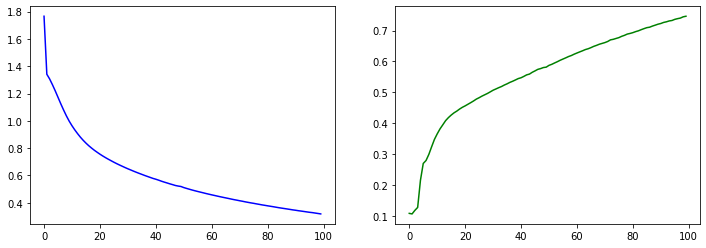

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')

plt.show()

## BLEU

In [ ]:
candidate = 'the the the the the the the'.split()
references = [
    'the cat is on the mat'.split(),
    'there is a cat on the mat'.split()
]

In [ ]:
candidate, references

(['the', 'the', 'the', 'the', 'the', 'the', 'the'],
 [['the', 'cat', 'is', 'on', 'the', 'mat'],
  ['there', 'is', 'a', 'cat', 'on', 'the', 'mat']])

In [ ]:
def get_ngram(tokens, ngram):
    # print(tokens)
    # tokens n-gram
    counter = collections.defaultdict(int)
    for i in range(len(tokens) - ngram + 1):
        # n-gram 별 count
        key = tuple(tokens[i:i+ngram]) # ngram에 따라 1이면 0~1, 1~2, 2~3되는거임
        counter[key] += 1 # key값에 따라 counter를 늘려가는것!
        print(i, key, counter)
    return  counter

In [ ]:
get_ngram(candidate, 2)

0 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 1})
1 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 2})
2 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 3})
3 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 4})
4 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 5})
5 ('the', 'the') defaultdict(<class 'int'>, {('the', 'the'): 6})


defaultdict(int, {('the', 'the'): 6})

In [ ]:
def get_ngram_clip(candidate, references, ngram):
    # max ref counter
    max_counter = collections.defaultdict(int)
    # check max count
    for ref in references:
        ref_counter = get_ngram(ref, ngram)
        for key, cnt in ref_counter.items():
            max_counter[key] = max(max_counter[key], ref_counter.get(key, 0)) # 래퍼런스의 값과 ,max counter의 값중 큰거를 가져오겟다
    # print(max_counter)

    # max reference counter를 해서 max값
    # candidate counter
    can_counter = get_ngram(candidate, ngram)
    # clip counter
    clip_counter = collections.defaultdict(int)
    for key, cnt in can_counter.items():
        clip_counter[key] = min(can_counter[key], max_counter.get(key, 0))
    return clip_counter

In [ ]:
get_ngram_clip(candidate, references, 1)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

defaultdict(int, {('the',): 2})

In [ ]:
def get_ngram_precision(candidate, references, ngram):
    # clip counter
    clip_counter = get_ngram_clip(candidate, references, ngram)
    n_clip = sum(clip_counter.values())
    # can counter
    can_counter = get_ngram(candidate, ngram)
    n_total = sum(can_counter.values())

    return n_clip / max(n_total, 1)  # 분모 0 방지

In [ ]:
get_ngram_precision(candidate, references, 1)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

0.2857142857142857

In [ ]:
def get_brevity_penalty(candidate, references):
    can_len = len(candidate)
    ref_len = min([len(reference) for reference in references])

    if can_len == 0:  # empty string
        return 0
    elif can_len > ref_len:
        return 1
    else:
        return np.exp(1 - ref_len / can_len)

In [ ]:
get_brevity_penalty(candidate, references)

1

In [ ]:
def get_bleu_score(candidate, references, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = get_brevity_penalty(candidate, references) # BP
    p_n = [] 
    for i in range(len(weights)): # ngram이 4이니까 
        p_n.append(get_ngram_precision(candidate, references, i + 1)) # 0,1,2,3일때를 다 계산
    score = [w * np.log(p) if p != 0 else 0 for p, w in zip(p_n, weights)] # precision과 weight를 같이 ㅓㅁ겨서
    score = np.sum(score)
    score = bp * np.exp(score)
    return score

In [ ]:
get_bleu_score(candidate, references)

0 ('the',) defaultdict(<class 'int'>, {('the',): 1})
1 ('cat',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1})
2 ('is',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1})
3 ('on',) defaultdict(<class 'int'>, {('the',): 1, ('cat',): 1, ('is',): 1, ('on',): 1})
4 ('the',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1})
5 ('mat',) defaultdict(<class 'int'>, {('the',): 2, ('cat',): 1, ('is',): 1, ('on',): 1, ('mat',): 1})
0 ('there',) defaultdict(<class 'int'>, {('there',): 1})
1 ('is',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1})
3 ('cat',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1})
4 ('on',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1})
5 ('the',) defaultdict(<class 'int'>, {('there',): 1, ('is',): 1, ('a',): 1, ('cat',): 1, ('on',): 1, ('the',): 1})
6 ('mat',) def

0.7311104457090247

In [ ]:
# 다른 라이브러리에서 가져올수 잇지
import nltk.translate.bleu_score as bleu
from nltk import ngrams

In [ ]:
bleu.sentence_bleu(references, candidate)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7311104457090247

In [ ]:
candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'.split()
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands'.split(),
    'It is the guiding principle which guarantees the military forces always being under the command of the Party'.split(),
    'It is the practical guide for the army always to heed the directions of the party'.split()
]

In [ ]:
get_bleu_score(candidate, references)

0 ('It',) defaultdict(<class 'int'>, {('It',): 1})
1 ('is',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1})
2 ('a',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1})
3 ('guide',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1})
4 ('to',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1})
5 ('action',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1})
6 ('that',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 1})
7 ('ensures',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 1, ('ensures',): 1})
8 ('that',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('that',): 2, ('ensures',): 1})
9 ('the',) defaultdict(<class 'int'>, {('It',): 1, ('is',): 1, 

0.5045666840058485

In [ ]:
bleu.sentence_bleu(references, candidate)

# 음 코드가 문제 없이 잘 돌아가고 있다는걸 알수가 있지

0.5045666840058485

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm.hdf5"))

In [ ]:
model.compile(loss=lm_loss, optimizer="adam", metrics=[lm_acc])

In [ ]:
# 100개만 확인
valid_enc_inputs = train_enc_inputs[:100]
valid_dec_inputs = train_dec_inputs[:100]
valid_dec_labels = train_dec_labels[:100]

In [ ]:
# 평가
model.evaluate((valid_enc_inputs, valid_dec_inputs), valid_dec_labels, batch_size=128)

1/1 [==============================] - 2s 2s/step - loss: 2.3758 - lm_acc: 0.2174


[2.3757662773132324, 0.21739129722118378]

In [ ]:
references = []
for row in valid_dec_labels: # 이거는 디코더 label이고
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    references.append(string)
references

[['▁그것', '▁또한', '▁감정', '의', '▁일부', '니까', '요', '.'],
 ['▁슈퍼', '라도', '▁가서', '▁쇼핑', '하고', '▁오', '세요', '.'],
 ['▁이혼', '이', '▁아니라', '▁다', '행', '입니다', '.'],
 ['▁비싸', '요', '.'],
 ['▁대화', '를', '▁하다가', '▁친', '해', '졌', '나', '봐', '요', '.'],
 ['▁신', '나', '는', '▁노래로', '▁분위기', '를', '▁', '띄', '어', '보', '세요', '.'],
 ['▁다른', '▁기회', '가', '▁올', '▁거', '예', '요', '.'],
 ['▁이제', '야', '▁깨달았', '나', '봐', '요', '.'],
 ['▁다른', '▁연락', '을', '▁많이', '▁하거나', '▁더', '▁자주', '▁만나', '세요', '.'],
 ['▁외모', '가', '▁중요한', '▁시대', '는', '▁끝', '났', '어요', '.']]

In [ ]:
# 예측
y_pred = model.predict((valid_enc_inputs, valid_dec_inputs))
y_pred.shape

(10, 40, 32007)

In [ ]:
# greedy decoding
y_pred_class = tf.argmax(y_pred, axis=-1).numpy()
y_pred_class

array([[ 506,  506,  506,  506,  506,    7,    7,    7,    3,    3,    3,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,  506,    7,    7,    7,    3,    7,    7,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,  506,  506,    7,    3,    7,    7,    7,
           7,    7,    7,    7,    7,    7,   57,   57,   57,   57,   57,
          57,   57,   57,   57,   57,   57,   57,   57,   57,   57, 2145,
        2145, 2145, 2145, 2145, 2145, 2145, 2145],
       [ 506,  506,  506,  506,    7,    7,    7,    7,    7,    7,    7,
           7,    7,    7,    7,    7,   57,   57,   57,   57,   57,   57,
          57,   57,   57,   57,  

In [ ]:
candidates = []
for row in y_pred_class:
    ids = []
    for i in row:
        if i == vocab.eos_id():
            break
        ids.append(int(i))
    string = vocab.id_to_piece(ids)
    candidates.append(string)
candidates

[['요', '요', '요', '요', '요', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.'],
 ['요',
  '요',
  '요',
  '요',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '나',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회',
  '▁기회'],
 ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.', '.'],
 ['요', '요', '요', '요', '요', '요', '.'],
 ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.'],
 ['요', '요', '요', '요', '.', '.', '.', '.', '.']]

In [ ]:
bleu_scores = []
for reference, candidate in zip(references, candidates):
    bleu_score = bleu.sentence_bleu([reference], candidate)
    bleu_scores.append(bleu_score)
    print(bleu_score, ":", reference, "/", candidate)
np.mean(bleu_scores)

0.43472087194499137 : ['▁그것', '▁또한', '▁감정', '의', '▁일부', '니까', '요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.']
0.5946035575013605 : ['▁슈퍼', '라도', '▁가서', '▁쇼핑', '하고', '▁오', '세요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.']
0.6147881529512643 : ['▁이혼', '이', '▁아니라', '▁다', '행', '입니다', '.'] / ['요', '요', '요', '요', '요', '요', '.']
0.1892240568795935 : ['▁비싸', '요', '.'] / ['요', '요', '요', '요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '나', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회', '▁기회']
0.3860973950960897 : ['▁대화', '를', '▁하다가', '▁친', '해', '졌', '나', '봐', '요', '.'] / ['요', '요', '요', '요', '요', '.', '.', '.', '.', '.']
0.537284965911771 : ['▁신', '나', '는', '▁노래로', '▁분위기', '를', '▁', '띄', '어', '보', '세요', '.'] / ['요', '요', '요', '요', '요', '요', '.', '.', '.', '.', '.', '.']
0.43472087194499137 : ['▁다른', '▁기회', '가', '▁올', '▁거', '예', '요', '.'] / ['요', '요', '요', '요', '요', '요', '.', '.']
0.467137977728

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4798269444338237

## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(sychat_dir, "lstm.hdf5"))

In [ ]:
def do_chat(vocab, model, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string) # 입력 문장
    q_id = [vocab.piece_to_id(p) for p in q]
    # print(q)

    # answer # 대답 문장
    a_id = [vocab.bos_id()]
    # print(a_id)
    # 처음부터 예측
    start_idx = 0 # Bos지 이거 지금

    # 어디까지 예측하느냐
    for _ in range(start_idx, n_dec_seq - 1):
        # print(q_id)
        # print(a_id)
        outputs = model.predict((np.array([q_id]), np.array([a_id]))) # (bs, n_seq, n_vocab)
        prob = outputs[0][start_idx] # 이때 우리 batch_size = 1이니까
        # print(prob.shape) # 32007개의 확률분포가 뽑혔지

        word_id = int(np.argmax(prob)) # 이제 greedy하게 뽑아보자 word_id에 저장되고
        # print(word_id)

        if word_id == vocab.eos_id(): #그리고 eos의 id가 오면 끝내라!
            break
        a_id.append(word_id)        
        start_idx += 1 # 뒤 단어가 계속 예측하도록 하겠지

    predict_id = a_id[1:start_idx + 1]
    # print(predict_id)
    predict_str = vocab.decode_ids(predict_id) # 받은 아이디를 string으로 바꿔야지
    return predict_str

In [ ]:
string = '남에게 피해주지 않는 건 기본이죠.'
do_chat(vocab, model, 40, string)

'좋은 사람 만나지 마세요.'

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, 40, string)
    print(f'답변 > {predict_str}')

질문 > 안녕
답변 > 기다려보세요.
질문 > 머선일이고
답변 > 기다려보세요.
질문 > 너는 누구니
답변 > 더 다가봐요.
질문 > 뭐라고?
답변 > 정리가 필요 없어요.
질문 > 무슨말이ㅑ
답변 > 괜찮아요.


KeyboardInterrupt: ignored